http://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

## Survival Regression
```Often we have additional data aside from the durations, and if applicable any censorships that occurred. In the regime dataset, we have the type of government the political leader was part of, the country they were head of, and the year they were elected. Can we use this data in survival analysis?```

```Yes, the technique is called survival regression – the name implies we regress covariates (eg: year elected, country, etc.) against a another variable – in this case durations and lifetimes. Similar to the logic in the first part of this tutorial, we cannot use traditional methods like linear regression.```

```There are two popular competing techniques in survival regression: Cox’s model and Aalen’s additive model. Both models attempt to represent the hazard rate λ(t). In Cox’s model, the relationship is defined:```


\begin{equation}
\lambda(t) = b_0(t) \exp(b_1x_1+...+b_nx_n)
\end{equation}

```On the other hand, Aalen’s additive model assumes the following form:```

\begin{equation}
\lambda(t) = b_0(t)+b_1(t)x_1+...+b_n(t)x_n
\end{equation}


In [2]:
%matplotlib inline
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

## Cox’s Proportional Hazard model
```Lifelines has an implementation of the Cox propotional hazards regression model (implemented in R under coxph). It has a similar API to Aalen’s additive model. Like R, it has a print_summary function that prints a tabular view of coefficients and related stats.```

```This example data is from the paper``` [here](http://socserv.socsci.mcmaster.ca/jfox/Books/Companion/appendix/Appendix-Cox-Regression.pdf).



In [9]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

cph.print_summary()  # access the results using cph.summary


n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3790     0.6845    0.1914 -1.9806 0.0476     -0.7542     -0.0039   *
age  -0.0572     0.9444    0.0220 -2.6042 0.0092     -0.1003     -0.0142  **
race  0.3141     1.3691    0.3080  1.0198 0.3078     -0.2897      0.9180    
wexp -0.1511     0.8597    0.2121 -0.7124 0.4762     -0.5670      0.2647    
mar  -0.4328     0.6487    0.3818 -1.1335 0.2570     -1.1813      0.3157    
paro -0.0850     0.9185    0.1957 -0.4341 0.6642     -0.4687      0.2988    
prio  0.0911     1.0954    0.0286  3.1824 0.0015      0.0350      0.1472  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640


```To access the coefficients and the baseline hazard, you can use cph.hazards_ and cph.baseline_hazard_ respectively. After fitting, you can use use the suite of prediction methods (similar to Aalen’s additve model above): .predict_partial_hazard, .predict_survival_function, etc.```


In [4]:
#cph.predict_partial_hazard(rossi_dataset.drop(["week", "arrest"], axis=1))


### Plotting the coefficients

```With a fitted model, an altervative way to view the coefficients and their ranges is to use the plot method.```


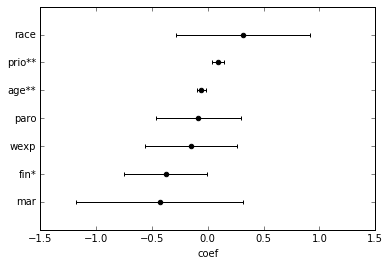

In [11]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

cph.plot()

### Checking the proportional hazards assumption
```A quick and visual way to check the proportional hazards assumption of a variable is to plot the survival curves segmented by the values of the variable. If the survival curves are the same “shape”, and differ only by constant factor, then the assumption holds. A more clear way to see this is to plot what’s called the loglogs curve: the log(-log(survival curve)) vs log(time). If the curves are parallel (and hence do not cross each other), then it’s likely the variable satisfies the assumption. If the curves do cross, likely you’ll have to “stratify” the variable (see next section). In lifelines, the KaplanMeierFitter object has a .plot_loglogs function for this purpose.```

```The following is the loglogs curves of two variables in our regime dataset. The first is the democracy type, which does have (close to) parallel lines, hence satisfies our assumption:```


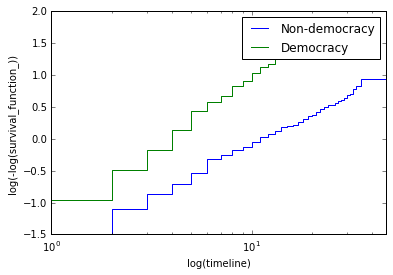

In [12]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter

data = load_dd()

democracy_0 = data.loc[data['democracy'] == 'Non-democracy']
democracy_1 = data.loc[data['democracy'] == 'Democracy']

kmf0 = KaplanMeierFitter()
kmf0.fit(democracy_0['duration'], event_observed=democracy_0['observed'])

kmf1 = KaplanMeierFitter()
kmf1.fit(democracy_1['duration'], event_observed=democracy_1['observed'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['Non-democracy', 'Democracy'])

plt.show()

## Stratification
```Sometimes a covariate may not obey the proportional hazard assumption. In this case, we can allow a factor to be adjusted for without estimating its effect. To specify categorical variables to be used in stratification, we specify them in the call to fit:
```



In [13]:
cph.fit(rossi_dataset, 'week', event_col='arrest', strata=['race'])

cph.print_summary()  # access the results using cph.summary


n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3775     0.6856    0.1913 -1.9731 0.0485     -0.7525     -0.0024   *
age  -0.0573     0.9443    0.0220 -2.6081 0.0091     -0.1004     -0.0142  **
wexp -0.1435     0.8664    0.2127 -0.6746 0.4999     -0.5603      0.2734    
mar  -0.4419     0.6428    0.3820 -1.1570 0.2473     -1.1907      0.3068    
paro -0.0839     0.9196    0.1958 -0.4283 0.6684     -0.4677      0.3000    
prio  0.0919     1.0962    0.0287  3.1985 0.0014      0.0356      0.1482  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.638


### Model Selection in Survival Regression
```If censorship is present, it’s not appropriate to use a loss function like mean-squared-error or mean-absolute-loss. Instead, one measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ordering of predicted time. It is infact a generalization of AUC, another common loss function, and is interpreted similarly:```

```
0.5 is the expected result from random predictions,
1.0 is perfect concordance and,
0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
```

```The measure is implemented in lifelines under lifelines.utils.concordance_index and accepts the actual times (along with any censorships) and the predicted times.```

### Cross validation

```Lifelines has an implementation of k-fold cross validation under lifelines.utils.k_fold_cross_validation. This function accepts an instance of a regression fitter (either CoxPHFitter of AalenAdditiveFitter), a dataset, plus k (the number of folds to perform, default 5). On each fold, it splits the data into a training set and a testing set, fits itself on the training set, and evaluates itself on the testing set (using the concordance measure).```




In [16]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

regression_dataset = load_regression_dataset()
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, regression_dataset, 'T', event_col='E', k=3)
print scores
print np.mean(scores)
print np.std(scores)


[0.60742574257425741, 0.52608903781713734, 0.57759456838021339]
0.570369782924
0.0335962599987


```
The End```